In [2]:
# Import modules for data wrangling
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas_profiling import ProfileReport
from datetime import datetime

In [3]:
# Read in .csv data to be cleaned
# Change global setting so that all columns will be displayed in dataframes and analyses
data = pd.read_csv('..\data\external\TTS_LBNL_public_file_07-Sep-2022_all.csv')
pd.set_option('display.max_columns', None)
data.head()

C:\Users\Zachary Brown\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,2,3,14,15,17,19,27,28,30,31,33,34,37,38,39,52,53,55,56,58,59,73,74,75) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,data_provider_1,data_provider_2,system_ID_1,system_ID_2,installation_date,system_size_DC,total_installed_price,rebate_or_grant,customer_segment,expansion_system,multiple_phase_system,new_construction,tracking,ground_mounted,zip_code,city,state,utility_service_territory,third_party_owned,installer_name,self_installed,azimuth_1,azimuth_2,azimuth_3,tilt_1,tilt_2,tilt_3,module_manufacturer_1,module_model_1,module_quantity_1,module_manufacturer_2,module_model_2,module_quantity_2,module_manufacturer_3,module_model_3,module_quantity_3,additional_modules,technology_module_1,technology_module_2,technology_module_3,BIPV_module_1,BIPV_module_2,BIPV_module_3,bifacial_module_1,bifacial_module_2,bifacial_module_3,nameplate_capacity_module_1,nameplate_capacity_module_2,nameplate_capacity_module_3,efficiency_module_1,efficiency_module_2,efficiency_module_3,inverter_manufacturer_1,inverter_model_1,inverter_quantity_1,inverter_manufacturer_2,inverter_model_2,inverter_quantity_2,inverter_manufacturer_3,inverter_model_3,inverter_quantity_3,additional_inverters,micro_inverter_1,micro_inverter_2,micro_inverter_3,built_in_meter_inverter_1,built_in_meter_inverter_2,built_in_meter_inverter_3,output_capacity_inverter_1,output_capacity_inverter_2,output_capacity_inverter_3,DC_optimizer,inverter_loading_ratio,dateOfBatteryInstall,battery_manufacturer,battery_model,battery_rated_capacity_kW,battery_rated_capacity_kWh
0,Massachusetts Clean Energy Center,Massachusetts Department of Energy Resources,GBI-JH4-00002,-1,26-Sep-2003,26.4,224000.00,241308.00,COM,0,0,-1,0,-1,2540,Falmouth,MA,NSTAR DBA EverSource,-1,Northern Pacific Power,0,170.0,-1.0,-1.0,8.0,-1,-1,-1,-1,88,-1,-1,-1,-1,-1,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,SMA America,SWR 2500U,11.0,-1,-1,-1,-1,-1,-1,0,0,-1,-1,1,-1,-1,2.5,-1.0,-1.0,0,0.96,-1,-1,-1,-1.0,-1.0
1,Massachusetts Clean Energy Center,Massachusetts Department of Energy Resources,CPV-LG8-00003,-1,17-Apr-2003,2.2,16621.00,9256.50,RES,0,0,-1,0,-1,2132,Boston,MA,NSTAR DBA EverSource,-1,Zapotec Energy,0,225.0,-1.0,-1.0,20.0,-1,-1,-1,-1,22,-1,-1,-1,-1,-1,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,SMA America,SWR 2500U,1.0,-1,-1,-1,-1,-1,-1,0,0,-1,-1,1,-1,-1,2.5,-1.0,-1.0,0,0.88,-1,-1,-1,-1.0,-1.0
2,Massachusetts Clean Energy Center,Massachusetts Department of Energy Resources,CPV-LG8-00004,-1,05-May-2003,2.2,16621.00,9256.50,RES,0,0,-1,0,-1,2458,Newton,MA,NSTAR DBA EverSource,-1,Zapotec Energy,0,180.0,-1.0,-1.0,20.0,-1,-1,-1,-1,22,-1,-1,-1,-1,-1,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,SMA America,SWR 2500U,1.0,-1,-1,-1,-1,-1,-1,0,0,-1,-1,1,-1,-1,2.5,-1.0,-1.0,0,0.88,-1,-1,-1,-1.0,-1.0
3,Massachusetts Clean Energy Center,Massachusetts Department of Energy Resources,CPV-LG8-00005,-1,25-Jun-2003,2.2,16621.00,9256.50,RES,0,0,-1,0,-1,2459,Newton,MA,NSTAR DBA EverSource,-1,Zapotec Energy,0,165.0,-1.0,-1.0,30.0,-1,-1,-1,-1,22,-1,-1,-1,-1,-1,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,SMA America,SWR 2500U,1.0,-1,-1,-1,-1,-1,-1,0,0,-1,-1,1,-1,-1,2.5,-1.0,-1.0,0,0.88,-1,-1,-1,-1.0,-1.0
4,Massachusetts Clean Energy Center,Massachusetts Department of Energy Resources,CPV-LG8-00006,-1,05-May-2003,2.1,16006.95,8835.75,RES,0,1,-1,0,-1,2464,Newton,MA,NSTAR DBA EverSource,-1,Zapotec Energy,0,178.0,-1.0,-1.0,25.0,-1,-1,-1,-1,21,-1,-1,-1,-1,-1,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,SMA America,SWR 2500U,1.0,-1,-1,-1,-1,-1,-1,0,0,-1,-1,1,-1,-1,2.5,-1.0,-1.0,0,0.84,-1,-1,-1,-1.0,-1.0


In [4]:
data.shape

(2362537, 78)

In [5]:
data.columns

Index(['data_provider_1', 'data_provider_2', 'system_ID_1', 'system_ID_2',
       'installation_date', 'system_size_DC', 'total_installed_price',
       'rebate_or_grant', 'customer_segment', 'expansion_system',
       'multiple_phase_system', 'new_construction', 'tracking',
       'ground_mounted', 'zip_code', 'city', 'state',
       'utility_service_territory', 'third_party_owned', 'installer_name',
       'self_installed', 'azimuth_1', 'azimuth_2', 'azimuth_3', 'tilt_1',
       'tilt_2', 'tilt_3', 'module_manufacturer_1', 'module_model_1',
       'module_quantity_1', 'module_manufacturer_2', 'module_model_2',
       'module_quantity_2', 'module_manufacturer_3', 'module_model_3',
       'module_quantity_3', 'additional_modules', 'technology_module_1',
       'technology_module_2', 'technology_module_3', 'BIPV_module_1',
       'BIPV_module_2', 'BIPV_module_3', 'bifacial_module_1',
       'bifacial_module_2', 'bifacial_module_3', 'nameplate_capacity_module_1',
       'nameplate_capaci

In [6]:
data.dtypes

data_provider_1                object
data_provider_2                object
system_ID_1                    object
system_ID_2                    object
installation_date              object
                               ...   
dateOfBatteryInstall           object
battery_manufacturer           object
battery_model                  object
battery_rated_capacity_kW     float64
battery_rated_capacity_kWh    float64
Length: 78, dtype: object

In [7]:
# I only want to analyze residential installations, so I need to check what the values in 'customer_segment' are that represent
# residential vs commercial
print(data['customer_segment'].unique())

['COM' 'RES' 'SCHOOL' 'GOV' 'NON-PROFIT' '-1' 'NON-RES']


In [8]:
# Now I'll subset the data to just residential installations
res_data = data[data['customer_segment'] == 'RES']
res_data.shape

(2262667, 78)

In [9]:
# I'm only interested in the most recent year of data - 2021 - so I'll first check to make sure that there are enough 
# installations to still create a valid model if I pare the data down to only 2021
newest_year = res_data['installation_date'].str[7:11] == '2021'
res_data[newest_year].shape

(276683, 78)

In [10]:
# Great! I still have >200,000 installations to analyze which should be plenty.
# Now I want to remove any rows that are missing 'total_installed_price' data since that's key to my metric for this prjoect.
# Missing data is encoded as -1 in this dataset according to the user guide
newest_res_data = res_data[newest_year].copy()
missing_sale = newest_res_data['total_installed_price'] == -1
newest_res_data = newest_res_data[~missing_sale]
newest_res_data.shape

(252253, 78)

In [11]:
# So it looks like we lost ~24k rows of missing sale data, which we can still work with
# Next I want to make sure that any missing values from the 'rebate_or_grant' column are 0 rather than -1 to avoid 
# changing the total sale price
print(min(newest_res_data['rebate_or_grant']))
newest_res_data['rebate_or_grant'] = newest_res_data['rebate_or_grant'].replace(-1, 0)
print(min(newest_res_data['rebate_or_grant']))

-1.0
0.0


In [12]:
# Now I'll convert the 'installation_date' column to datetime
newest_res_data['installation_date'] = pd.to_datetime(newest_res_data['installation_date'])
newest_res_data.dtypes

data_provider_1                       object
data_provider_2                       object
system_ID_1                           object
system_ID_2                           object
installation_date             datetime64[ns]
                                   ...      
dateOfBatteryInstall                  object
battery_manufacturer                  object
battery_model                         object
battery_rated_capacity_kW            float64
battery_rated_capacity_kWh           float64
Length: 78, dtype: object

In [13]:
# Rather than have the model attempt to process each day of the year, it makes more sense to break the date into bins by 
# month
newest_res_data['installation_month'] = newest_res_data['installation_date'].dt.month
newest_res_data['installation_month'].value_counts().sort_index()

1     18523
2     17780
3     21797
4     19606
5     17770
6     21382
7     25080
8     22526
9     20841
10    20912
11    22260
12    23776
Name: installation_month, dtype: int64

In [14]:
# Now I'll confirm that the monetary columns are correctly detected as floats
newest_res_data[['total_installed_price', 'rebate_or_grant']].dtypes

total_installed_price    float64
rebate_or_grant          float64
dtype: object

In [15]:
# To perform some preliminary checks I'll take a look at the .describe() results for the pared down dataset
newest_res_data.describe(include='all', datetime_is_numeric=True)

,data_provider_1,data_provider_2,system_ID_1,system_ID_2,installation_date,system_size_DC,total_installed_price,rebate_or_grant,customer_segment,expansion_system,multiple_phase_system,new_construction,tracking,ground_mounted,zip_code,city,state,utility_service_territory,third_party_owned,installer_name,self_installed,azimuth_1,azimuth_2,azimuth_3,tilt_1,tilt_2,tilt_3,module_manufacturer_1,module_model_1,module_quantity_1,module_manufacturer_2,module_model_2,module_quantity_2,module_manufacturer_3,module_model_3,module_quantity_3,additional_modules,technology_module_1,technology_module_2,technology_module_3,BIPV_module_1,BIPV_module_2,BIPV_module_3,bifacial_module_1,bifacial_module_2,bifacial_module_3,nameplate_capacity_module_1,nameplate_capacity_module_2,nameplate_capacity_module_3,efficiency_module_1,efficiency_module_2,efficiency_module_3,inverter_manufacturer_1,inverter_model_1,inverter_quantity_1,inverter_manufacturer_2,inverter_model_2,inverter_quantity_2,inverter_manufacturer_3,inverter_model_3,inverter_quantity_3,additional_inverters,micro_inverter_1,micro_inverter_2,micro_inverter_3,built_in_meter_inverter_1,built_in_meter_inverter_2,built_in_meter_inverter_3,output_capacity_inverter_1,output_capacity_inverter_2,output_capacity_inverter_3,DC_optimizer,inverter_loading_ratio,dateOfBatteryInstall,battery_manufacturer,battery_model,battery_rated_capacity_kW,battery_rated_capacity_kWh,installation_month
count,252253,252253,252253.0,252253,252253,252253.000000,2.522530e+05,252253.000000,252253,252253.000000,252253.000000,252253.000000,252253.000000,252253.000000,252253.0,252253.0,252253,252253,252253.000000,252253,252253.000000,252253.000000,252253.000000,252253.000000,252253.000000,252253.000000,252253.000000,252253,252253.0,252253.000000,252253,252253,252253.000000,252253,252253,252253.000000,252253.000000,252253,252253,252253,252253.000000,252253.000000,252253.000000,252253.000000,252253.000000,252253.000000,252253.000000,252253.000000,252253.000000,252253.000000,252253.000000,252253.000000,252253,252253,252253.000000,252253,252253,252253.000000,252253,252253,252253.000000,252253.000000,252253.000000,252253.000000,252253.000000,252253.000000,252253.000000,252253.000000,252253.000000,252253.000000,252253.000000,252253.000000,252253.000000,252253,252242,252242,252253.000000,252253.000000,252253.000000
unique,20,6,238740.0,6978,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,8974.0,3743.0,16,112,NaN,2751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120,2304.0,NaN,80,606,NaN,49,329,NaN,NaN,7,7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55,405,NaN,37,174,NaN,22,83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,469,24,47,NaN,NaN,NaN
top,California Public Utilities Commission,-1,-1.0,-1,NaN,NaN,NaN,NaN,RES,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0,CA,Pacific Gas and Electric,NaN,Sunrun Inc.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hanwha Q CELLS,-1.0,NaN,-1,-1,NaN,-1,-1,NaN,NaN,Monocrystalline,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SolarEdge Technologies Ltd.,IQ7PLUS-72-2-US [240V],NaN,-1,-1,NaN,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,NaN,NaN,NaN
freq,175140,171501,11188.0,168191,NaN,NaN,NaN,NaN,252253,NaN,NaN,NaN,NaN,NaN,11464.0,17204.0,175140,84674,NaN,37529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51151,23481.0,NaN,183491,183491,NaN,182605,182605,NaN,NaN,213222,183491,182605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83955,32658,NaN,195135,195721,NaN,195401,195458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200532,194184,201657,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,2021-07-08 02:03:21.026746624,8.306388,2.987161e+04,262.912837,NaN,0.066160,0.003223,-0.968143,-0.232624,-0.258625,NaN,NaN,NaN,NaN,0.179562,NaN,-0.049268,142.349217,4.739179,1.262423,15.005419,-0.097446,-0.642101,NaN,NaN,15.612361,NaN,NaN,-0.518198,NaN,NaN,-0.881547,-0.205278,NaN,NaN,NaN,-0.136993,-0.963354,-0.986759,-0.132645,-0.963560,-0.986791,298.526546,11.202650,3.452483,0.018697,-0.957484,-0.984512,NaN,NaN,8.351143,NaN,NaN,-0.954978,NaN,NaN,-0.996571,-0.210273

<function matplotlib.pyplot.show(close=None, block=None)>

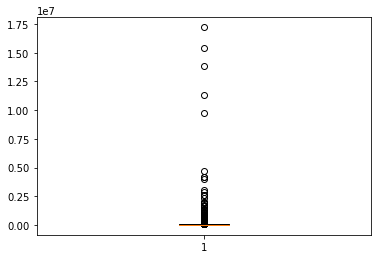

In [16]:
# Now I'll plot a box plot of 'total_installed_price' to look for outliers and to determine if there is 
# a threshold below which we can safely say the values are erroneous or placeholders
plt.boxplot(newest_res_data['total_installed_price'])
plt.show

In [17]:
# There are a lot of potential outliers shown in this box plot, so let's take a look at summary statistics and a histogram 
newest_res_data['total_installed_price'].describe()

count    2.522530e+05
mean     2.987161e+04
std      6.896266e+04
min      1.000000e-02
25%      1.770000e+04
50%      2.570400e+04
75%      3.681000e+04
max      1.721412e+07
Name: total_installed_price, dtype: float64

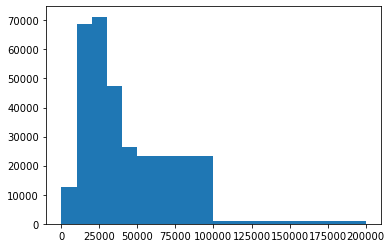

In [18]:
plt.hist(newest_res_data['total_installed_price'], bins=[-1,100,10000,20000,30000,40000,50000,100000,200000])
plt.show()

In [19]:
# That minimum still looks erroneous, and though the max values are very high we can't rule out that maybe some wealthy
# people had large panels installed, so we'll leave those. I'll dig into those low values and see if there is any clear
# indication of what's erroneous.
print(list(sorted(newest_res_data['total_installed_price'].unique()))[:10])

[0.01, 0.1, 0.18, 0.31, 1.0, 2.0, 2.6, 2.67, 2.68, 3.0]


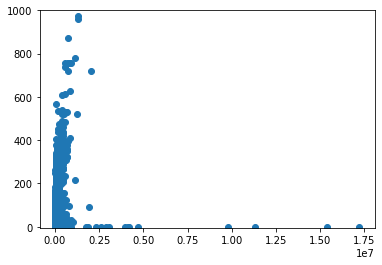

In [34]:
# As shown above there's a very continuous range of prices, so I can't clearly say that below X price everything else is 
# erroneous or a sign of omission. Instead, I'm going to take a look at the ratio of 'total_installed_price' against 
# 'module_quantity_1' which would be expected to be directly correlated. Any values falling far outside of the scatter could
# possibly be an outlier.
plt.scatter(newest_res_data['total_installed_price'],newest_res_data['module_quantity_1'])
plt.ylim([-5,1000])
plt.show()

In [ ]:
# I can go ahead and create the final price column that will be my metric for the model
newest_res_data['final_price'] = newest_res_data['total_installed_price'] - newest_res_data['rebate_or_grant']

In [ ]:
# res_data.profile_report()